# Function to Load Data

In [2]:
#import fcm
import os
import re
import glob
import random
import numpy as np
import scipy
import scipy.io as sio
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.patches import Patch, Circle
from matplotlib.lines import Line2D
from PIL import Image
import ipywidgets as ipw
from ipywidgets import interact, interactive, fixed, interact_manual  # package for interactive widgets 
import braingeneers                                                   # Braingeneers code
from braingeneers.analysis.analysis import SpikeData, read_phy_files
import braingeneers.data.datasets_electrophysiology as ephys
from IPython.display import HTML, display, Javascript, clear_output

In [3]:
import io
import zipfile
from typing import List, Tuple

def read_phy_files(path: str, fs=20000.0):
    """
    :param path: a s3 or local path to a zip of phy files.
    :return: SpikeData class with a list of spike time lists and neuron_data.
            neuron_data = {0: neuron_dict, 1: config_dict}
            neuron_dict = {"new_cluster_id": {"channel": c, "position": (x, y),
                            "amplitudes": [a0, a1, an], "template": [t0, t1, tn],
                            "neighbor_channels": [c0, c1, cn],
                            "neighbor_positions": [(x0, y0), (x1, y1), (xn,yn)],
                            "neighbor_templates": [[t00, t01, t0n], [tn0, tn1, tnn]}}
            config_dict = {chn: pos}
    """
    assert path[-3:] == 'zip', 'Only zip files supported!'
    import braingeneers.utils.smart_open_braingeneers as smart_open
    with smart_open.open(path, 'rb') as f0:
        f = io.BytesIO(f0.read())

        with zipfile.ZipFile(f, 'r') as f_zip:
            assert 'params.py' in f_zip.namelist(), "Wrong spike sorting output."
            with io.TextIOWrapper(f_zip.open('params.py'), encoding='utf-8') as params:
                for line in params:
                    if "sample_rate" in line:
                        fs = float(line.split()[-1])
            clusters = np.load(f_zip.open('spike_clusters.npy')).squeeze()
            templates = np.load(f_zip.open('templates.npy'))  # (cluster_id, samples, channel_id)
            channels = np.load(f_zip.open('channel_map.npy')).squeeze()
            templates_w = np.load(f_zip.open('templates.npy'))
            wmi = np.load(f_zip.open('whitening_mat_inv.npy'))
            spike_templates = np.load(f_zip.open('spike_templates.npy')).squeeze()
            spike_times = np.load(f_zip.open('spike_times.npy')).squeeze() / fs * 1e3  # in ms
            positions = np.load(f_zip.open('channel_positions.npy'))
            amplitudes = np.load(f_zip.open("amplitudes.npy")).squeeze()
            if 'cluster_info.tsv' in f_zip.namelist():
                cluster_info = pd.read_csv(f_zip.open('cluster_info.tsv'), sep='\t')
                cluster_id = np.array(cluster_info['cluster_id'])
                # select clusters using curation label, remove units labeled as "noise"
                # find the best channel by amplitude
                labeled_clusters = cluster_id[cluster_info['group'] != "noise"]
            else:
                labeled_clusters = np.unique(clusters)

    df = pd.DataFrame({"clusters": clusters, "spikeTimes": spike_times, "amplitudes": amplitudes})
    cluster_agg = df.groupby("clusters").agg({"spikeTimes": lambda x: list(x),
                                              "amplitudes": lambda x: list(x)})
    cluster_agg = cluster_agg[cluster_agg.index.isin(labeled_clusters)]

    cls_temp = dict(zip(clusters, spike_templates))
    neuron_dict = dict.fromkeys(np.arange(len(labeled_clusters)), None)

    # un-whitten the templates before finding the best channel
    templates = np.dot(templates_w, wmi)

    neuron_attributes = []
    for i in range(len(labeled_clusters)):
        c = labeled_clusters[i]
        temp = templates[cls_temp[c]]
        amp = np.max(temp, axis=0) - np.min(temp, axis=0)
        sorted_idx = [ind for _, ind in sorted(zip(amp, np.arange(len(amp))))]
        nbgh_chan_idx = sorted_idx[::-1][:12]
        nbgh_temps = temp.transpose()[nbgh_chan_idx]
        best_chan_temp = nbgh_temps[0]
        nbgh_channels = channels[nbgh_chan_idx]
        nbgh_postions = [tuple(positions[idx]) for idx in nbgh_chan_idx]
        best_channel = nbgh_channels[0]
        best_position = nbgh_postions[0]
        # neighbor_templates = dict(zip(nbgh_postions, nbgh_temps))
        cls_amp = cluster_agg["amplitudes"][c]
        neuron_dict[i] = {"cluster_id": c, "channel": best_channel, "position": best_position,
                          "amplitudes": cls_amp, "template": best_chan_temp,
                          "neighbor_channels": nbgh_channels, "neighbor_positions": nbgh_postions,
                          "neighbor_templates": nbgh_temps}
        neuron_attributes.append(
            NeuronAttributes(
                cluster_id=c,
                channel=best_channel,
                position=best_position,
                amplitudes=cluster_agg["amplitudes"][c],
                template=best_chan_temp,
                templates=templates[cls_temp[c]].T,
                label=cluster_info['group'][cluster_info['cluster_id'] == c].values[0],
                neighbor_channels=channels[nbgh_chan_idx],
                neighbor_positions=[tuple(positions[idx]) for idx in nbgh_chan_idx],
                neighbor_templates=[templates[cls_temp[c]].T[n] for n in nbgh_chan_idx]
            )
        )

    config_dict = dict(zip(channels, positions))
    neuron_data = {0: neuron_dict}
    metadata = {0: config_dict}
    spikedata = SpikeData(list(cluster_agg["spikeTimes"]), neuron_data=neuron_data, metadata=metadata, neuron_attributes=neuron_attributes)
    return spikedata

class NeuronAttributes:
    cluster_id: int
    channel: np.ndarray
    position: Tuple[float, float]
    amplitudes: List[float]
    template: np.ndarray
    templates: np.ndarray
    label: str

    # These lists are the same length and correspond to each other
    neighbor_channels: np.ndarray
    neighbor_positions: List[Tuple[float, float]]
    neighbor_templates: List[np.ndarray]

    def __init__(self, *args, **kwargs):
        self.cluster_id = kwargs.pop("cluster_id")
        self.channel = kwargs.pop("channel")
        self.position = kwargs.pop("position")
        self.amplitudes = kwargs.pop("amplitudes")
        self.template = kwargs.pop("template")
        self.templates = kwargs.pop("templates")
        self.label = kwargs.pop("label")
        self.neighbor_channels = kwargs.pop("neighbor_channels")
        self.neighbor_positions = kwargs.pop("neighbor_positions")
        self.neighbor_templates = kwargs.pop("neighbor_templates")
        for key, value in kwargs.items():
            setattr(self, key, value)

    def add_attribute(self, key, value):
        setattr(self, key, value)

    def list_attributes(self):
        return [attr for attr in dir(self) if not attr.startswith('__') and not callable(getattr(self, attr))]

# Code from before


In [1]:
#import fcm
import os
import re
import glob
import random
import numpy as np
import scipy
import scipy.io as sio
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.patches import Patch, Circle
from matplotlib.lines import Line2D
from PIL import Image
import ipywidgets as ipw
from ipywidgets import interact, interactive, fixed, interact_manual  # package for interactive widgets 
import braingeneers                                                   # Braingeneers code
from braingeneers.analysis.analysis import SpikeData, read_phy_files
import braingeneers.data.datasets_electrophysiology as ephys
from IPython.display import HTML, display, Javascript, clear_output

In [2]:
print("hello")

hello


In [3]:
def analyze_spike_data(sd):
    idces_control, times_control = sd.idces_times()
    n_neurons_control = len(sd.rates())

    print("Number of spikes: ", len(idces_control))
    print("Length: ", int(times_control[-1]/1000), "seconds")
    print("Number of Neurons: ", n_neurons_control)
    entire_firing_rate_control = len(idces_control) / (times_control[-1] / 1000)
    avg_rate_control = entire_firing_rate_control / n_neurons_control
    print("Average Firing Rate: ", round(avg_rate_control, 2))

    isis_raw = sd.interspike_intervals()
    # Remove all isi's greater than 100ms. As there are likely neurons not following periodic firing pattern
    isis = []
    for i in range(len(isis_raw)):
        isi = isis_raw[i]
        isis = isis + isi[isi < 100].tolist()

    isi_mean = sum(isis) / len(isis)
    isi_var = sum([((x - isi_mean) ** 2) for x in isis]) / len(isis)
    isi_std = isi_var ** 0.5
    cv = isi_std / isi_mean
    print("Coefficient of Variation: ", round(cv,3) )

In [4]:
def GetTextSummary(folder_name):
    path = f"/home/jovyan/work/Human_Hippocampus/data/ephys/{folder_name}/derived/kilosort2/"
    file_extension = "_curated.zip"
    spike_data_objects = {}  # Dictionary to store spike data objects

    def get_last_digit(s):
        return int(''.join(filter(str.isdigit, s))[-1])

    for filename in os.listdir(path):
        if filename.endswith(file_extension):
            file_path = os.path.join(path, filename)
            try:
                sd = read_phy_files(file_path)
                sd.original_file = filename
                # Generating the unique name for the spike data object based on the last digit of the filename
                sd_name = "sd_" + str(get_last_digit(filename))
                spike_data_objects[sd_name] = sd
            except:
                print(f"WARNING: Unable to Read < {filename} >")
    print("-----------------------------")       
    for sd_name in sorted(spike_data_objects.keys(), key=lambda x: int(x.split("_")[-1])):
        sd_object = spike_data_objects[sd_name]
        #print(f"Analyzing {sd_name}...")
        print(f"Filename: {sd_object.original_file}:")
        analyze_spike_data(sd_object)
        print("-----------------------------")

# Checking Perturbed Data

## Helper function

In [5]:
def plot_raster(sd):
    idces, times = sd.idces_times()
    fig, ax = plt.subplots()

    ax.scatter(times/1000,idces,marker='|',s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    plt.show()

## Plot spike raster

In [7]:
from braingeneers.analysis import load_spike_data

In [13]:
braingeneers.set_default_endpoint("/home/jovyan/data/ephys/2023-04-02-e-hc328_unperturbed")

In [15]:
full_path="/home/jovyan/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip"
sd = load_spike_data(uuid="2023-04-02-e-hc328_unperturbed",full_path=full_path)
#analyze_spike_data(sd)

prefix: ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/
Using full path, experiment: hc3


In [16]:
sd.N

3

In [5]:
full_path="/home/jovyan/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip"
sd = read_phy_files( full_path )

In [6]:
sd.N

140

In [ ]:
file_path="/home/jovyan/work/Human_Hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip"
sd = read_phy_files(file_path)
#analyze_spike_data(sd)

# <font color="brown"> Scratch Paper

In [6]:
file_path="/home/jovyan/work/Human_Hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip"
sd = read_phy_files(file_path)
#analyze_spike_data(sd)


FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/work/Human_Hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip'

In [ ]:
def plot_raster(sd, start, end ):
    
    idces, times = sd.idces_times()
    #plt.figure(figsize=(20,10))
    fig, ax = plt.subplots(figsize=(20,10))
    

    ax.scatter(times/1000,idces,marker='|',s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    plt.xlim( start, end)
    plt.show()

In [ ]:
min_start=0
max_end = 400

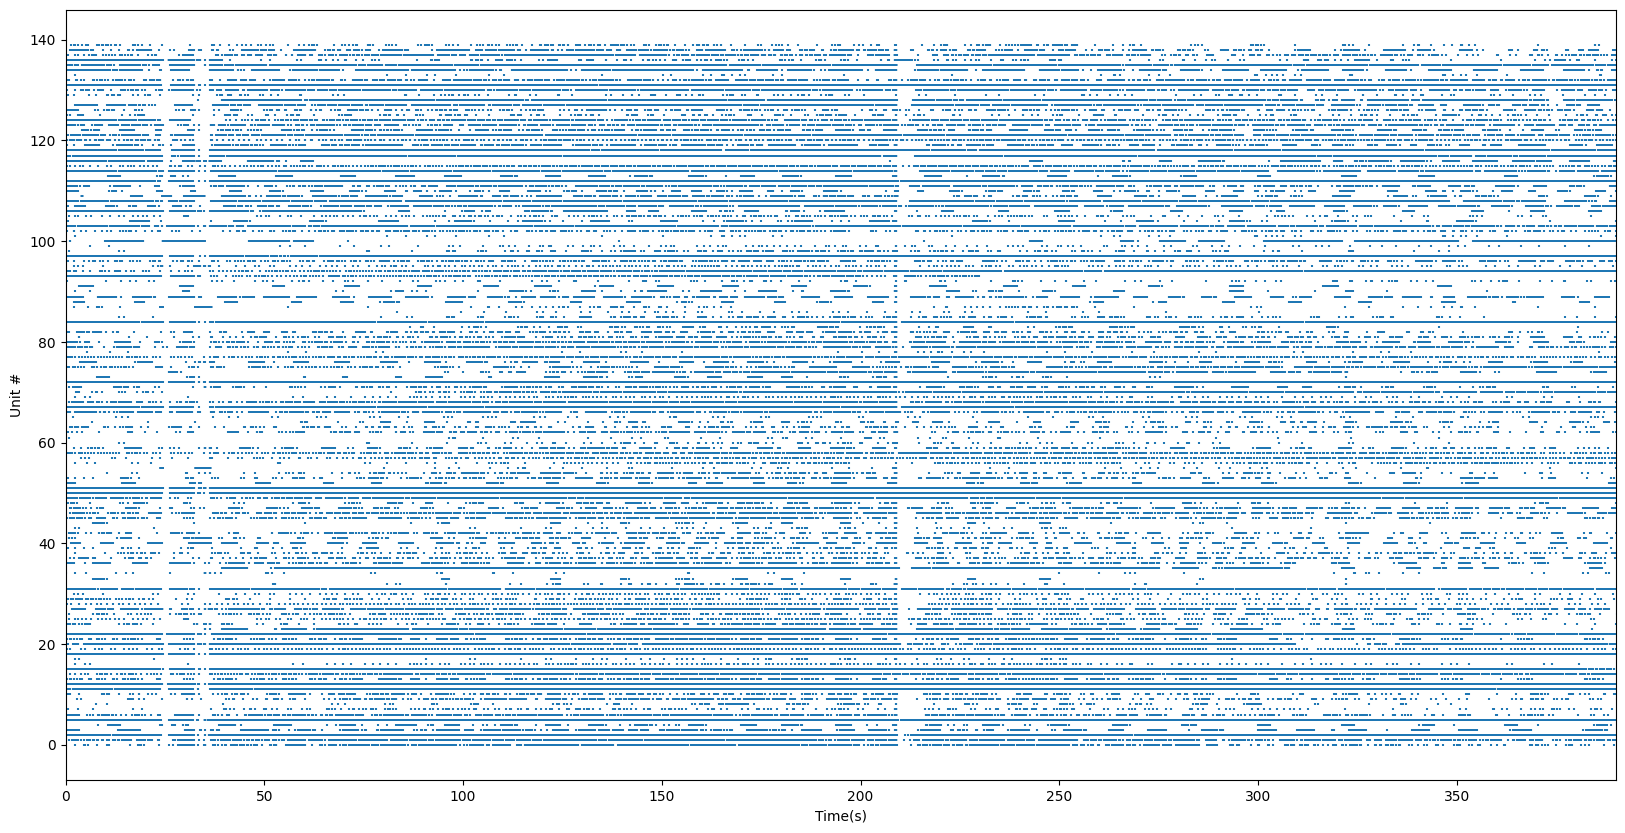

In [ ]:
plot_raster(sd, 0,390)